 Alex Approach

# K-anonymous clustering 2 step partition

The k-anonymous clustering with 2- step partition approach involves 2 steps to creating a publishable-sanitized dataset. While this approach is not all that unique, it is a simpler approach to previous research that has been published.  Additionally, we also focus on the approach that picks the best clusters for the anonymized datasets.  Previously published research tends to center on picking a pre-defined algorithm or modification of a pre-defined algorithm.  Therefore, this approach is must more robust from the perspective of providing hte best clusterings we can while also balancing anonymity.  This approach will also allow for out of the box algorithms to be used with little modification.  This allows for DBAs not familiar with more complex clustering implementation to take our code and implement it immediately with few checks.  Additionally, we highlight some of the pitfalls associated with this approach as well as potential solutions to the problem.


* First, we remove all explicit identifiers (This is our supression step).
    - removing explicit identifiers will enable us to remove all features which allow for the specific identification of a subject.  We much weigh these items accordingly as we may be able to use some of these features in the next step while still maintaining anaonymity in the final dataset.  Items that should be removed in this step are features such as name and social security number.  We can leave attributes such as data of birth in this dataset, because we can use these values to create the groupings in the next step.
    
* Secondly, we will run a clustering algorithm on the remaining set of identifiers that make up the quasi-identifier of the explicitly sanitized dataset.  We will call the explicitly santized dataset the interim dataset that exists in memory between steps 1 and 2. This is our generalization step.  The explicitly santized dataset will never be shared with the broader audience as this would most certainly allow for the identification of individuals in the dataset.  
    - Note that some identifiers may not be quantitative and may need to be discretized of simply thrown out.  We always err on the side of conservatism in this approach.  
    - Once the clusters are run, we gather the ranges of values that are representative within each of the clusters.  We should note that in some cases, we may have overlapping values within the clusters.  In this case, we should either add futher discretization to the clustering feature groups or we could manually discretize and resort within the initialization cluster.  If this step is taken, we must test for that feature representation combination to still retain k-ananymous groupings.  While this step introduces a somewhat manual solution to anonymization within the automated step, it ensures that publishers are studying the data that they put out for public consumption and avoids adding considerable amounts of complexity to the existing algorithm

* Once generalization is complete, we can then create the table of published clusters and paired tuple data.  In this case, we are actually going to publish 2 datasets.  One dataset will be our cluster groupings.  The other dataset will be our tuple-level dataset that contains the original number of N records.  The cartesian product of these 2 recordsets allows for the creation of a single cohesive dataset that contains k-1 values for each of the aggregated groupings within the dataset.  That being said, the initial statistical significance of the resultant dataset is retained at the level of specificity that is allowed within the cluster.  This is an important point to note.  This approach allows us to control the level of depth to which a given datset can be deduced.  This adds another level of anonymity in a sense.  If the clustered quasi-identifier is infact more anaonymous than necessary, then the publisher is actually able to further anonymize the dataset.  This is an important feature as it allows for the publishing of data that is increasingly sensitive.  That being said, this increases the level of responsibility relegated to the data publisher.  This point brings us to the next step in our publishability checks

* Once the clusters have been checked for k-anonymous groupings, the publisher needs to maintain a series of checks and databases upon which to check the data against in pre-publication. This ensures that attackers will not be able to mate up information.  The publisher should maintain 3 series of databases against which to check the datasrouces.  It should also be noted that this can be done algorithmically so that the publisher need not rewrite the process with each iteration. The database type breakdown is as follows:
    - Datasources previously published by the publisher
    - Datasources previously published by sources other than the publisher
    - Datasources previously published by public entities 
 

In [2]:
# hypothetical k-anonymous 2-step partition

import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
import sklearn as sk
import statsmodels.api as sm
#import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pandas.tools.plotting import scatter_plot
from pandas.tools.plotting import scatter_matrix

from sklearn.preprocessing import scale, StandardScaler
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression, Lasso, Lars, SGDRegressor

from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt
#from crypt import AES
import random


#import locale
#locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

from pandas.tools.plotting import scatter_matrix

from sklearn.svm import SVR
from sklearn.feature_selection import RFE, RFECV

from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline

#configure the random seed so we our randomness is reproducible for selection of learn/test sets
np.random.seed(0)

%matplotlib inline



C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [101]:
# first load the dataset in, we will combine the 2 datasets needed, this is not part of the anonymization process

# NOTE: These records are 100% hypothetical Public airline records were taken and joined with completely randomized 
# data.  All birthdates, genders, and zipcodes were generated with random algorithms.  All names were taken combined
# from the US census bureau's lists of male first names, female first names, and lastnames from the 1990 U.S. census

customers = pd.read_csv('customer.csv')

customer_flights = pd.read_csv('cust_flight.csv')



In [102]:
print( customers.shape, customer_flights.shape)

(10000, 7) (53027, 5)


In [103]:
customer_flights.head()

,origin,destination,departure_date,flight_route_number,customer
0,PHX,STL,5/30/2016,281,0
1,DAL,ABQ,5/19/2016,42,0
2,OAK,SAN,5/9/2016,18,0
3,SAN,BNA,5/28/2016,585,0
4,SJC,SAN,5/11/2016,527,0


In [104]:
customers.head()

,CustomerNumber,Gender,Age,ZipCode,TotalFlights,first_name,last_name
0,0,0,37,67570,9,KAMI,SMITH
1,1,1,39,60474,0,JAMES,JOHNSON
2,2,1,43,94066,0,JOHN,WILLIAMS
3,3,0,41,94572,7,LINDA,JONES
4,4,1,47,2646,7,MICHAEL,BROWN


In [7]:
# let's combine the 2 dataframes to work with for our anonymization


new_customers = customer_flights.merge(right = customers, left_on = 'customer', right_on = 'CustomerNumber', how = 'left')


In [8]:
new_customers.head()

,origin,destination,departure_date,flight_route_number,customer,CustomerNumber,Gender,Age,ZipCode,TotalFlights,first_name,last_name
0,PHX,STL,5/30/2016,281,0,0,0,37,67570,9,KAMI,SMITH
1,DAL,ABQ,5/19/2016,42,0,0,0,37,67570,9,KAMI,SMITH
2,OAK,SAN,5/9/2016,18,0,0,0,37,67570,9,KAMI,SMITH
3,SAN,BNA,5/28/2016,585,0,0,0,37,67570,9,KAMI,SMITH
4,SJC,SAN,5/11/2016,527,0,0,0,37,67570,9,KAMI,SMITH


In [9]:
# we should see 53,027 records and 12 columns in the new dataset

new_customers.shape

(53027, 12)

In [10]:
# great the dataset now looks good.


### Step 1: remove explicit identifiers - subjective


In this dataset, the explicit identifiers are simple.  The name of the customer and the customer number are the only explicit identifier; therefore, we will just remove the name columns


In [116]:
for col in ['first_name','last_name', 'CustomerNumber', 'customer']:
    if col in customers:
        del customers[col]

In [21]:
print (list(customers))

['Gender', 'Age', 'ZipCode', 'TotalFlights']


We are now left with a series of flights taken by each customer.  We have now removed the customer specific information from the records, but we need to further anonymize so that an attacker cannot back into the information about a customer.  

### Step 2: Cluster on the quasi-identifier


In [59]:
from sklearn import metrics
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import StandardScaler


## Changing to using customers, that is a better way to do it...
quasi_identifier = np.array(customers[['Gender','Age','ZipCode','TotalFlights']])

#quasi_identifier = np.array(new_customers[['Gender']])

scl = StandardScaler() # import the standardscaler
scaled_quasi_identifier = scl.fit_transform(quasi_identifier)

cluster_list =  [5, 6, 7, 8, 9, 10, 11, 12, 13]


for cluster in cluster_list:
        cls  = KMeans(n_clusters = cluster, init = 'k-means++')
        cls.fit(scaled_quasi_identifier)
        labels = cls.labels_
        
        print( cluster, ":", cls.inertia_ )
        


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


5 : 19343.3013275
6 : 17368.3635737
7 : 15684.7421662
8 : 14102.3970258
9 : 13113.8710238
10 : 12228.5914482
11 : 11485.4451907
12 : 10707.2992251
13 : 10229.0729258


In [23]:
# now, mate up the customers with their cluster

type(labels)

numpy.ndarray

In [29]:
clustered_customers = np.column_stack((customers, labels))

In [30]:
clustered_customers = pd.DataFrame(clustered_customers)

In [105]:
clustered_customers.columns = ['Gender','Age','zipcode','total_flights', 'cluster']

In [35]:
clustered_customers.describe()

,Gender,Age,zipcode,total_flights,cluster
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,0.508500,43.442500,49828.587000,5.30270,3.414600
std,0.499953,4.788673,27790.168748,5.33062,2.314226
min,0.000000,26.000000,715.000000,0.00000,0.000000
25%,0.000000,40.000000,25843.000000,0.00000,1.000000
50%,1.000000,43.000000,48410.000000,4.00000,3.000000
75%,1.000000,47.000000,73154.000000,9.00000,5.000000
max,1.000000,60.000000,99733.000000,29.00000,7.000000


In [60]:
customers_grouped = clustered_customers.groupby(by='cluster')

In [61]:
# show cluster sizes

customers_grouped.count()

,Gender,Age,zipcode,total_flights
cluster,,,,
0,1124,1124,1124,1124
1,1603,1603,1603,1603
2,1486,1486,1486,1486
3,1129,1129,1129,1129
4,797,797,797,797
5,1450,1450,1450,1450
6,1131,1131,1131,1131
7,1280,1280,1280,1280


In [62]:
customers_grouped.Age.min() 

cluster
0    26
1    28
2    26
3    30
4    30
5    29
6    29
7    29
Name: Age, dtype: int64

In [63]:
customers_grouped.Age.max() 

cluster
0    59
1    60
2    59
3    58
4    56
5    60
6    59
7    58
Name: Age, dtype: int64

In [50]:
customers_grouped = clustered_customers.groupby(by=['cluster','Gender'])

In [51]:
customers_grouped.Gender.count() 

cluster  Gender
0        0         543
         1         581
1        0         803
         1         800
2        0         711
         1         775
3        0         554
         1         575
4        0         404
         1         393
5        0         712
         1         738
6        0         550
         1         581
7        0         638
         1         642
Name: Gender, dtype: int64

In [52]:
customers_grouped.total_flights.sum() 

cluster  Gender
0        0         2881
         1         3151
1        0         4329
         1         4223
2        0         3598
         1         4182
3        0         3005
         1         3246
4        0         2264
         1         2100
5        0         3638
         1         3940
6        0         2920
         1         2880
7        0         3289
         1         3381
Name: total_flights, dtype: int64

### Step 2 - Alternative - Discretization

In cases where clustering provides an invalid final solution, an alternative approach includes discretization and grouping of all variables.  This creates K x I groupings within the final dataset.  In this case, it is especially important to ensure that we have k-anaonymity for each particular grouping.  The rules implemented with this approach are that boolean vectors are split on the vector, whereas other values are discretized so as to mimic the original distribution of classes.

In [106]:
# male/female

# no coding needed for gender as it is already done

customers['male_female'] = pd.cut(customers.Gender,[-1,0,1e6], labels = ['female','male'])

customers[['male_female','Gender']].head()

,male_female,Gender
0,female,0
1,male,1
2,male,1
3,female,0
4,male,1


count    10000.000000
mean        43.442500
std          4.788673
min         26.000000
25%         40.000000
50%         43.000000
75%         47.000000
max         60.000000
Name: Age, dtype: float64


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


<function matplotlib.pyplot.show>

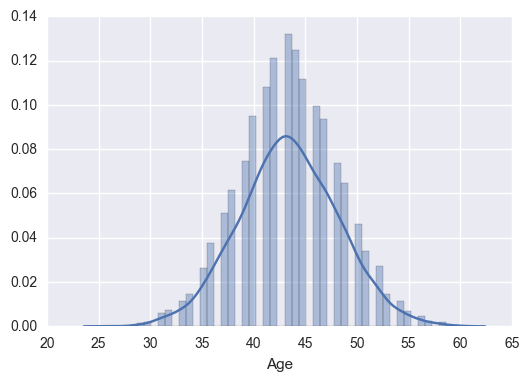

In [107]:
customers['Age'].describe()

ax = sns.distplot(customers['Age'])

print( customers['Age'].describe())
plt.show

In [108]:
# age discretization

customers['age_category'] = pd.cut(customers.Age,[0,40,43,47,1e6], labels = ['young','mature','old','senior'])

In [109]:
customers[['age_category','Age']].head()

,age_category,Age
0,young,37
1,young,39
2,mature,43
3,mature,41
4,old,47


In [110]:
customers_grouped = customers.groupby(by=['age_category'])
                                                    
customers_grouped.age_category.count()                                                    

age_category
young     2653
mature    2458
old       2924
senior    1965
Name: age_category, dtype: int64

count    10000.00000
mean         5.30270
std          5.33062
min          0.00000
25%          0.00000
50%          4.00000
75%          9.00000
max         29.00000
Name: TotalFlights, dtype: float64


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


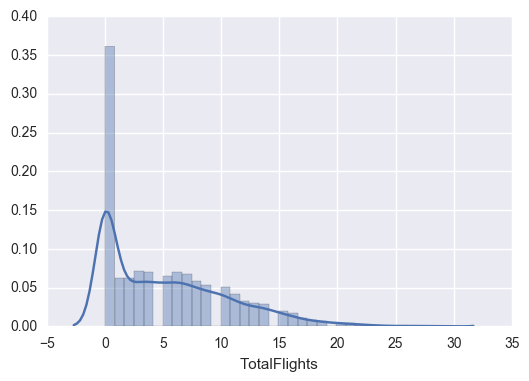

In [111]:
# total flights discretization

ax = sns.distplot(customers['TotalFlights'])

print(customers['TotalFlights'].describe())

In [112]:
customers['frequent_flier_category'] = pd.cut(customers.TotalFlights,[-1, 5, 9, 1e6], labels = ['low','medium','high'])

customers[['frequent_flier_category','TotalFlights']].head()

,frequent_flier_category,TotalFlights
0,medium,9
1,low,0
2,low,0
3,medium,7
4,medium,7


In [113]:
# For this exercise we will drop zipcode.  
#In a better approach, we would create distances between zips and group based on closest zips. Since this is only illustrative that is not necesary

del customers['ZipCode']


In [117]:
customers.describe()

,Gender,Age,TotalFlights
count,10000.000000,10000.000000,10000.00000
mean,0.508500,43.442500,5.30270
std,0.499953,4.788673,5.33062
min,0.000000,26.000000,0.00000
25%,0.000000,40.000000,0.00000
50%,1.000000,43.000000,4.00000
75%,1.000000,47.000000,9.00000
max,1.000000,60.000000,29.00000


In [115]:
customers.dtypes

CustomerNumber                int64
Gender                        int64
Age                           int64
TotalFlights                  int64
first_name                   object
last_name                    object
male_female                category
age_category               category
frequent_flier_category    category
dtype: object